In [12]:
#packages import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.utils import resample

In [13]:
#dataset import
#test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
validation_data = pd.read_csv("validation.csv")

#Apply CTR estimation to create linear bidding strategy, proportional to pCTR

#bid = base_bid * pCTR /avgCTR
#base_bid - the big price for the avg CTR cases


Apply CTR estimation to create a linear bidding strategy. The bid value is linearly proportional to the pCTR
(predicted CTR). The formula can be generally written as
bid = base bid×pCT R/avgCTR, 
where the tuning parameter
base bid is the bid price for the average CTR cases. Optimise the base bid and the CTR estimation and evaluate the
performance of your model using the metrics as defined in
Section 3.3. Discuss and compare your results.

mCPC - the max cost per click

Linear-form bidding of pCTR (Lin) - Parametic as it considers the bugit limit when the parameters are tuned.
Also needs to evaluate the CTR for each impression

CTR - click through rate - # of clicks over winning impressions

In [14]:
list(train_data)

['click',
 'weekday',
 'hour',
 'bidid',
 'userid',
 'useragent',
 'IP',
 'region',
 'city',
 'adexchange',
 'domain',
 'url',
 'urlid',
 'slotid',
 'slotwidth',
 'slotheight',
 'slotvisibility',
 'slotformat',
 'slotprice',
 'creative',
 'bidprice',
 'payprice',
 'keypage',
 'advertiser',
 'usertag']

In [16]:
# check the action win rate for impressions
win_rate = round(len(train_data.loc[train_data['bidprice'] > train_data['payprice']])*100/len(train_data), 2)

print(str(win_rate) + "% impression win rate")


99.89% impression win rate


In [17]:
train_data = train_data.loc[train_data['bidprice'] > train_data['payprice']]
train_data['adexchange'] = train_data['adexchange'].fillna(0)
train_data.head(3)

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,...,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,NaN
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,...,250,FourthView,Na,0,10722,294,23,NaN,2821,NaN
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,...,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110"


In [18]:
print("baseline")
print("data click mean %.3f" % train_data['click'].mean())

baseline
data click mean 0.001


In [19]:
train_data['click'].value_counts()/len(train_data)

0    0.999265
1    0.000735
Name: click, dtype: float64

In [20]:
train_data['click'].value_counts()

0    2426443
1       1785
Name: click, dtype: int64

In [21]:
'''Because there is such a huge disparity between non-clicks vs clicks, we'll perform a:
Negative downsampling (imbalanced): different samples sizes are used in this procedure. 
In all these samples all the observations from the minority class are kept and 
we take different number of observations from the majority class by performing sampling without replacement.
'''
# Separate majority and minority classes
train_data_majority = train_data[train_data.click==0]
train_data_minority = train_data[train_data.click==1]
 
# Downsample majority class
df_majority_downsampled = resample(train_data_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1785,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
train_data = pd.concat([df_majority_downsampled, train_data_minority])
 
# Display new class counts
train_data.click.value_counts()

1    1785
0    1785
Name: click, dtype: int64

In [22]:
# Determine average click through rate based on useragent
useragent_mean = train_data.groupby('useragent')['click'].agg(['mean']).sort_values(['mean'],ascending=False)
useragent_mean

,mean
useragent,
android_chrome,1.000000
ios_other,1.000000
ios_safari,1.000000
other_other,1.000000
android_other,0.923077
android_safari,0.873900
mac_safari,0.832168
mac_other,0.800000
linux_chrome,0.800000


In [23]:
# Determine average click through rate based on advertiser
advertiser_mean = train_data.groupby('advertiser')['click'].agg(['mean']).sort_values(['mean'],ascending=False)
advertiser_mean

,mean
advertiser,
2997,0.878543
3358,0.528796
1458,0.514825
3427,0.483813
3386,0.476762
3476,0.457213
2821,0.445578
2259,0.302817
2261,0.274809


In [24]:
# Determine average click through rate based on pricing of the slot
slotprice_mean = train_data.groupby('slotprice')['click'].agg(['mean']).sort_values(['mean'],ascending=False)
#slotprice_mean

In [25]:
# Determine average click through rate based on pricing bidding
bidprice_mean = train_data.groupby('bidprice')['click'].agg(['mean']).sort_values(['mean'],ascending=False)
bidprice_mean

,mean
bidprice,
277,0.649510
227,0.572559
254,0.525510
300,0.496806
241,0.494845
238,0.421053
294,0.399015
249,0.336634


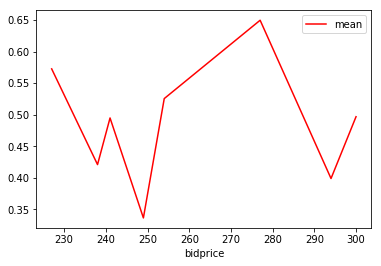

In [26]:
fig, ax = plt.subplots()
train_data.groupby('bidprice')['click'].agg(['mean']).plot(ax=ax, c='red', label='unclicked')
plt.show()

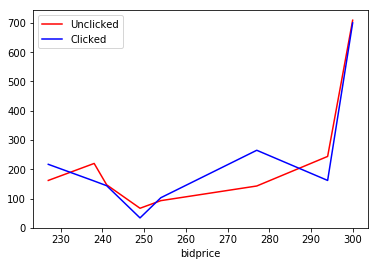

In [27]:
unclick_ad = train_data.loc[train_data['click'] ==0]
clicked_ad = train_data.loc[train_data['click'] ==1]

fig, ax = plt.subplots()
unclick_ad.groupby('bidprice')['click'].agg(['count']).plot(ax=ax, c='red', label='unclicked')
clicked_ad.groupby('bidprice')['click'].agg(['count']).plot(ax=ax, c='blue', label='clicked')

L = plt.legend()
L.get_texts()[0].set_text('Unclicked')
L.get_texts()[1].set_text('Clicked')

plt.show()


In [28]:
# create a dataframe from this df 
# that includes all the features we want to test

#headers: 

model_df = train_data[
['click',
 'weekday',
 'hour',
 #'bidid',
 #'userid',
 #'useragent',
 #'IP',
 'region',
 'city',
 'adexchange',
 #'domain',
 #'url',
 #'urlid',
 #'slotid',
 'slotwidth',
 'slotheight',
 #'slotvisibility',
 #'slotformat',
 'slotprice',
 #'creative',
 'bidprice',
 'payprice',
 #'keypage',
 'advertiser',
 #'usertag'
]]

#model_df['keypage'] =model_df['keypage'].astype(str)
#categorical_columns = ['useragent','slotvisibility', 'slotformat', 'keypage']

#categorical_columns = ['keypage']


#model_df = generate_ohe(model_df, categorical_columns)
#model_df

In [29]:
def generate_ohe(df, col_list):
    for col in col_list:
        gen_ohe = OneHotEncoder()
        gen_feature_arr = gen_ohe.fit_transform(model_df[[col]]).toarray()
        gen_feature_labels = list(gen_le.classes_)
        gen_features = pd.DataFrame(gen_feature_arr, columns=gen_feature_labels)
        df= pd.concat([df, gen_features], axis=1)
    return df                                           

In [30]:
array = model_df.values
X = array[:,1:len(train_data.columns)]
y = array[:,0]
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, y)
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features)

[1.068e-01 5.925e+01 1.527e+02 1.569e+02 3.616e+01 6.699e+02 7.218e+02
 3.947e+02 1.497e+00 6.071e+03 7.681e+01]
[[  34.  320.   50.    5.  128.]
 [   5.  300.  250.   31.   33.]
 [  83.  120.  600.  180.  180.]
 ...
 [ 167.  160.  600.    0.   18.]
 [   5.  300.  250.    0.  127.]
 [   1. 1000.   90.   70.   70.]]


In [31]:
top_feat = list(np.argsort(fit.scores_))
print("Top features include: %s, %s, %s, %s, %s" %   
      (model_df.columns[top_feat.index(10)], model_df.columns[top_feat.index(9)],
       model_df.columns[top_feat.index(8)], model_df.columns[top_feat.index(7)], 
       model_df.columns[top_feat.index(6)]))


Top features include: city, payprice, weekday, slotheight, bidprice
